# CSII 2023 Exercise 05: Discretization Methods for Duckiebot Steering

Reference: 
- [Python Control Systems Library](https://python-control.readthedocs.io/en/0.9.3.post2/steering.html)
- Karl J. Astrom and Richard M. Murray 23 Jul 2019

## Discretization Methods for Duckiebot Steering
The dynamics of the Duckiebot are given by a simple unicycle model, which is similar to the Duckiebot model presented in the first lecture. We take the state of the system as $(x, y, \theta)$ where $(x, y)$ is the position of the reference point of the Duckiebot in the plane and $\theta$ is the angle of the Duckiebot with respect to the x-axis. The input of the Duckiebot is given by $(v, \omega)$ where $v$ is the forward velocity and $\omega$ is the angular speed. The difference from the lecture formulation is that we use absolute coordinates in global frame $(x, y, \theta)$ for our states and not relative states to our reference line as shown in the figure $(d,\theta)$.

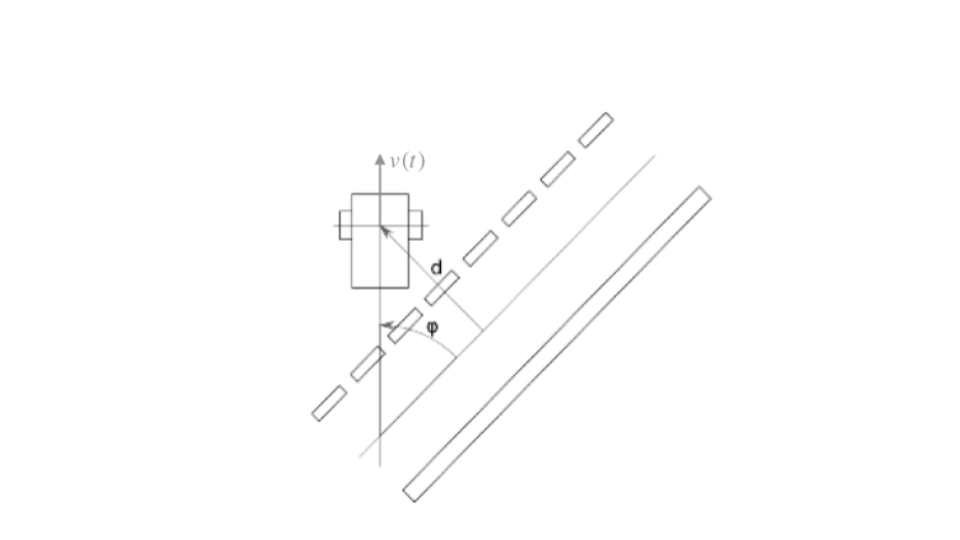

You have already seen this model multiple times however it will be the first time that we discretizes the duckiebot. Discrete time systems are closer to reality than our continous theoretical model. Every sensor and also every computer chip has a frequency. A real duckiebot would recieve discrete inputs and our controller would return descrete outputs. 

In this part of the notebook we will look a bit closer at the effect that certain discretization methods have on the performance of our duckiebot steering controller.

-------
## Installation 
We use the [Python library](https://python-control.readthedocs.io/en/0.9.3.post2/) `control`, which can be installed using `pip`. If you have no experience with Python, try to do some tutorials (e.g. check [this](https://docs.python.org/3/tutorial/) one). The same goes for installing Python packages using `pip`, see this [tutorial](https://packaging.python.org/en/latest/tutorials/installing-packages/). There are plenty of other Python tutorials for beginners if you do a Google/YouTube search. 

In [1]:
# Install the required python library with pip 
!pip install control

------
## Python Packages
We use the following Python libraries which need to be imported. If you have no experience with the [NumPy](https://numpy.org/) library, read the documentation and do some tutorials. It is very important for matrix operations in Python.

In [2]:
# Import the required python libraries
from typing import Optional, List
import numpy as np
import matplotlib.pyplot as plt
import control as ct

## Dynamics

The nonlinear dynamics and the output of the Duckiebot are defined in the next cell.

In [3]:
def unicycle_update(t: float, x: np.array, u: np.array, params: dict):
    # Return the derivative of the state
    max_omega = params.get('max_omega', 0.05)
    omega = np.clip(u[1], -max_omega, max_omega)
    return np.array([
        u[0] * np.cos(x[2]),    # xdot = v cos(theta)
        u[0] * np.sin(x[2]),    # ydot = v sin(theta)
        omega     # thdot = w
    ])

def unicycle_output(t: float, x: np.array, u: np.array, params: dict):
    return x[0:2]

## Plotting
The next cell implements some plotting functions using the [Matplotlib](https://matplotlib.org/) library. If you are interested, take a look.

In [4]:
#@title
def plot_track(x_coord_ref: np.array, y_coord_ref: np.array, 
               theta_ref: np.array, t: np.array, 
               w_curvy: np.array, 
               y_ctr: Optional[np.array] = None,
               w_ctr: Optional[np.array] = None) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    plt.figure(figsize=[9, 4.5])
    # Plot the resulting trajectory (and some road boundaries)
    plt.subplot(1, 4, 2)
    plt.plot(y_coord_ref, x_coord_ref)
    plt.legend(['reference'])
    if y_ctr is not None:
        plt.plot(y_ctr, x_coord_ref, 'r', linewidth=1)
        plt.legend(['reference', 'controller'])
    else:
        plt.legend(['reference'])
    plt.plot(y_coord_ref - 0.9/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    plt.plot(y_coord_ref - 0.3/np.cos(theta_ref), x_coord_ref, 'k--', linewidth=1)
    plt.plot(y_coord_ref + 0.3/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    
    
    
    plt.xlabel('y [m]')
    plt.ylabel('x [m]');
    plt.axis('Equal')

    # Plot the lateral position
    plt.subplot(2, 2, 2)
    plt.plot(t, y_coord_ref)
    if y_ctr is not None:
        plt.plot(t_curvy, y_ctr, 'r')
        plt.legend(['reference', 'controller'])
    else:
        plt.legend(['reference'])
    plt.ylabel('Lateral position $y$ [m]')

    # Plot the control input
    plt.subplot(2, 2, 4)
    plt.plot(t, w_curvy)
    if w_ctr is not None:
        plt.plot(t_curvy, w_ctr, 'r')
        plt.legend(['reference', 'controller'])
    else:
        plt.legend(['reference'])
    plt.ylabel('$\\omega$ [rad/s]')
    plt.xlabel('Time t [sec]')
    plt.tight_layout()


def plot_track_multiple_controller(x_coord_ref: np.array, y_coord_ref: np.array, 
               theta_ref: np.array, t: List[np.array], 
               w_curvy: np.array, 
               y_ctr: List[np.array],
               w_ctr: Optional[np.array]) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    number_ctr = len(t)
    plt.figure(figsize=[14, 6])
    # Plot the resulting trajectory (and some road boundaries)

    plt.subplot(1, 4, 2)
    plt.plot(y_coord_ref, x_coord_ref)
    plt.legend(['reference'])
    legend_list = ['reference']
    for i in range(number_ctr):
        plt.plot(y_ctr[i], x_coord_ref, linewidth=1)
        legend_list.append(f'controller_{i}')
    
    plt.legend(legend_list, loc='upper left')
    plt.plot(y_coord_ref - 0.9/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    plt.plot(y_coord_ref - 0.3/np.cos(theta_ref), x_coord_ref, 'k--', linewidth=1)
    plt.plot(y_coord_ref + 0.3/np.cos(theta_ref), x_coord_ref, 'k-', linewidth=1)
    
    
    
    plt.xlabel('y [m]')
    plt.ylabel('x [m]');
    plt.axis('Equal')

    # Plot the lateral position
    plt.subplot(2, 2, 2)
    plt.plot(t[0], y_coord_ref)
    legend_list = ['reference']
    for i in range(number_ctr):
        plt.plot(t[i], y_ctr[i], linewidth=1)
        legend_list.append(f'controller_{i}')
    plt.legend(legend_list)
    plt.ylabel('Lateral position $y$ [m]')

    # Plot the control input
    plt.subplot(2, 2, 4)
    plt.plot(t[0], w_curvy)
    for i in range(number_ctr):
        plt.plot(t[i], w_ctr[i], linewidth=1)
        legend_list.append(f'controller_{i}')
    plt.legend(legend_list)
    plt.ylabel('$\\omega$ [rad/s]')
    plt.xlabel('Time t [sec]')
    plt.tight_layout()

# Utility function to plot the step response
def plot_step_response(t: np.array, y: np.array, u: np.array):
    axes_out = plt.subplot(2, 1, 1)
    plt.sca(axes_out)
    plt.plot(t, y)
    plt.ylabel('Lateral position $y$ in [m]')
    plt.plot([0, 20], [0.95, 0.95], 'k--')
    plt.plot([0, 20], [1.05, 1.05], 'k--')
    
    axes_input = plt.subplot(2, 1, 2)
    plt.sca(axes_input)
    plt.xlabel('Time t [sec]')
    plt.ylabel('$\omega$ [rad/s]')
    plt.plot(t, u[0])

def plot_sim_results(y_ref: np.array, y: np.array, 
                     theta_ref: np.array, theta: np.array,
                     t: np.array, w_ref: np.array,
                     w: np.array) -> None:
    # Configure matplotlib plots to be a bit bigger and optimize layout
    plt.figure(figsize=[15, 4.5])

    # Plot the actual and estimated states
    ax = plt.subplot(1, 2, 1)
    plt.plot(t, y)
    plt.plot(t, y_ref, 'k-.')
    ax.set(xlim=[0, 30])
    plt.legend(['state feedback', 'y', 'reference'])
    plt.xlabel('Time t [sec]')
    plt.ylabel('Lateral position $y$ [m]')

    ax = plt.subplot(2, 2, 2)
    plt.plot(t, theta)
    # plt.plot(t, x[3])
    plt.plot(t, theta_ref, 'k-.')
    ax.set(xlim=[0, 15])
    plt.ylabel('Angle $\\theta$ [rad]')

    ax = plt.subplot(2, 2, 4)
    plt.plot(t, w)
    # plt.plot(t, u_ofb[0])
    plt.plot(t, w_ref, 'k-.')
    ax.set(xlim=[0, 15])
    plt.xlabel('Time t [sec]')
    plt.ylabel('$\\omega$ [rad/s]')

## Parameters and Reference Track

We set a default Duckiebot velocity and generate the nonlinear system using the `control` library.

In [5]:
# Default Duckiebot velocity in m/s
duckie_params={'velocity': 0.1, 'max_omega': 0.05}
# Define the Duckiebot's steering dynamics as an input/output system
duckiebot = ct.NonlinearIOSystem(
    unicycle_update, unicycle_output, states=3, name='duckiebot',
    inputs=('v', 'w'), outputs=('x', 'y'), params=duckie_params)

v0 = duckie_params['velocity']

We define a reference track that we want to follow. If you want to test an easy track, set `curve_difficulty_levels[0]`. For a hard track set `curve_difficulty_levels[1]`. If you want to create your own track, set `curve_difficulty_levels[2]` and change `w_curvy` after the `else` line. The reference line is generated by simulating some given control inputs for a certain time. We keep the velocity input `v_curvy` constant and calculate a forced angluar velocity `w_curvy`.

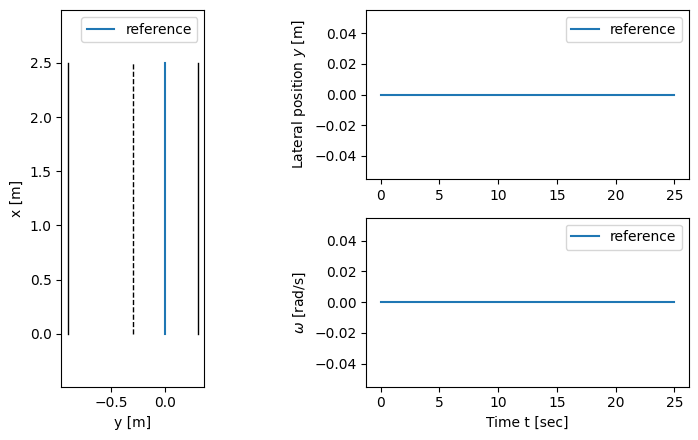

In [6]:
# Control inputs
curve_difficulty_levels = ['easy', 'hard', 'straignt']
curve_difficulty = curve_difficulty_levels[2]
T_curvy = np.linspace(0, 25, 500)
v_curvy = v0*np.ones(T_curvy.shape)
if curve_difficulty=='easy':
    w_curvy = 0.025*np.sin(T_curvy*np.pi/50)
elif curve_difficulty=='hard':
    w_curvy = 0.2*np.sin(T_curvy)*np.cos(4*T_curvy) + 0.025*np.sin(T_curvy*np.pi/10)
else:
    w_curvy = np.zeros(T_curvy.shape)
u_curvy = [v_curvy, w_curvy]
X0_curvy = [0, 0, 0]

# Simulate the system + estimator
t_curvy, y_curvy, x_curvy = ct.input_output_response(
    duckiebot, T_curvy, u_curvy, X0_curvy, params=duckie_params, return_x=True)

plot_track(y_curvy[0], y_curvy[1], x_curvy[2], t_curvy, w_curvy)
y_ref = x_curvy[1]
r = np.expand_dims(y_ref, axis=0)
t = T_curvy

## Linearization, Normalization and State Space Represenation

In the next cell we show you how you to linearize and normalize the system using the `control` library. As shown in the class, we use $u_1=v_0$ as a constant for simplicity.

In [7]:
# Define the lateral dynamics as a subset of the full Duckiebot steering dynamics
lateral = ct.NonlinearIOSystem(
    lambda t, x, u, params: unicycle_update(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    lambda t, x, u, params: unicycle_output(
        t, [0., x[0], x[1]], [params.get('velocity', 1), u[0]], params)[1:],
    states=2, name='lateral', inputs=('w'), outputs=('y')
)

# Compute the linearization at velocity v0 = 0.1 m/sec
lateral_linearized = ct.linearize(lateral, [0, 0], [0], params=duckie_params)

print("Linearized system dynamics:\n")
print(lateral_linearized)

# Save the system matrices for later use
A = lateral_linearized.A
B = lateral_linearized.B
C = lateral_linearized.C

Linearized system dynamics:

<LinearIOSystem>: sys[2]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[0.  0.1]
     [0.  0. ]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]



-------
## Implementation of Descretization Methods

### Euler Forward Method

add explanation

In [8]:
def euler_forward(A, B, C, dt):
    """
    Discretize a continuous-time system using the Euler forward method.
    
    Parameters:
    A, B, C: State-space matrices of the continuous-time system.
    dt: Time step for discretization.
    
    Returns:
    Ad, Bd, Cd: Discretized state-space matrices.
    """
    I = np.eye(A.shape[0])
    Ad = I + dt * A
    Bd = dt * B
    Cd = C
    return Ad, Bd, Cd

### Euler Backwards Method

add explanation

In [9]:
def euler_backward(A, B, C, dt):
    """
    Discretize a continuous-time system using the Euler backward method.
    
    Parameters:
    A, B, C: State-space matrices of the continuous-time system.
    dt: Time step for discretization.
    
    Returns:
    Ad, Bd, Cd: Discretized state-space matrices.
    """
    I = np.eye(A.shape[0])
    Ad = np.linalg.inv(I - dt * A)
    Bd = np.dot(Ad, dt * B)
    Cd = C
    return Ad, Bd, Cd

### Tustin's Method

add explanation

In [10]:
def tustin_method(A, B, C, dt):
    """
    Discretize a continuous-time system using Tustin's method (bilinear transformation).
    
    Parameters:
    A, B, C: State-space matrices of the continuous-time system.
    dt: Time step for discretization.
    
    Returns:
    Ad, Bd, Cd: Discretized state-space matrices.
    """
    I = np.eye(A.shape[0])
    pre_matrix = np.linalg.inv(I - (dt / 2) * A)
    Ad = np.dot(pre_matrix, I + (dt / 2) * A)
    Bd = np.dot(pre_matrix, dt * B)
    Cd = C
    return Ad, Bd, Cd

-------
## Exercise 1: Stability Analysis with Eigenvalue Plots

Objective: Analyze and compare the stability of the Duckiebot steering system using different discretization methods.

Tasks:

	1.Discretize the system using Euler forward, Euler backward, and Tustin’s methods for a given time step (e.g., dt = 0.1 seconds).

	2.Calculate the eigenvalues of the Ad matrix for each method.
	
	3.Plot these eigenvalues on the complex plane. Stable systems will have eigenvalues with magnitudes less than 1.

## Solution Exercise 1

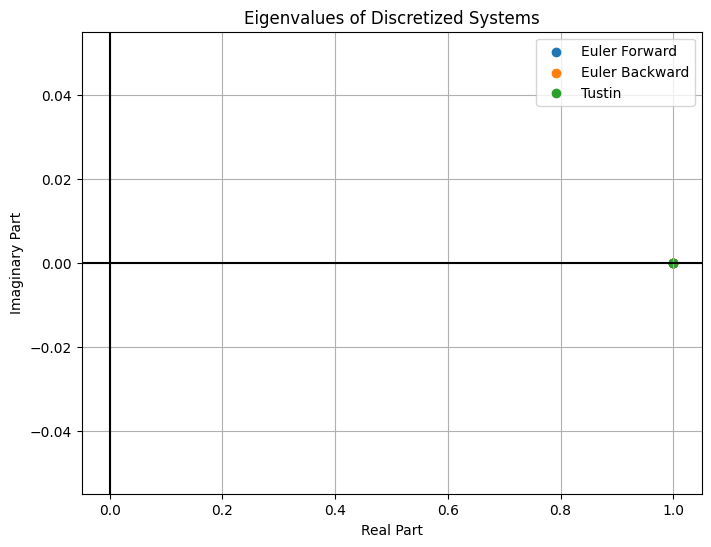

In [11]:
dt = 0.1  # Time step

# Discretize using each method
Ad_forward, Bd_forward, Cd_forward = euler_forward(A, B, C, dt)
Ad_backward, Bd_backward, Cd_backward = euler_backward(A, B, C, dt)
Ad_tustin, Bd_tustin, Cd_tustin = tustin_method(A, B, C, dt)

# Function to plot eigenvalues
def plot_eigenvalues(Ad, method_name):
    eigenvalues = np.linalg.eigvals(Ad)
    plt.scatter(eigenvalues.real, eigenvalues.imag, label=method_name)

# Plot eigenvalues
plt.figure(figsize=(8, 6))
plot_eigenvalues(Ad_forward, 'Euler Forward')
plot_eigenvalues(Ad_backward, 'Euler Backward')
plot_eigenvalues(Ad_tustin, 'Tustin')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Eigenvalues of Discretized Systems')
plt.legend()
plt.grid(True)
plt.show()

## Exercise 2: Step Response Simulation and Comparison

Objective: Simulate and compare the step responses of the discretized systems.

Tasks:

	1.Apply a step input to each discretized system.
	2.Simulate the response over a fixed time period (e.g., 10 seconds).
	3.Plot the responses from all three methods on the same graph for comparison.

## Solution Exercise 2

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (100, 1) + inhomogeneous part.

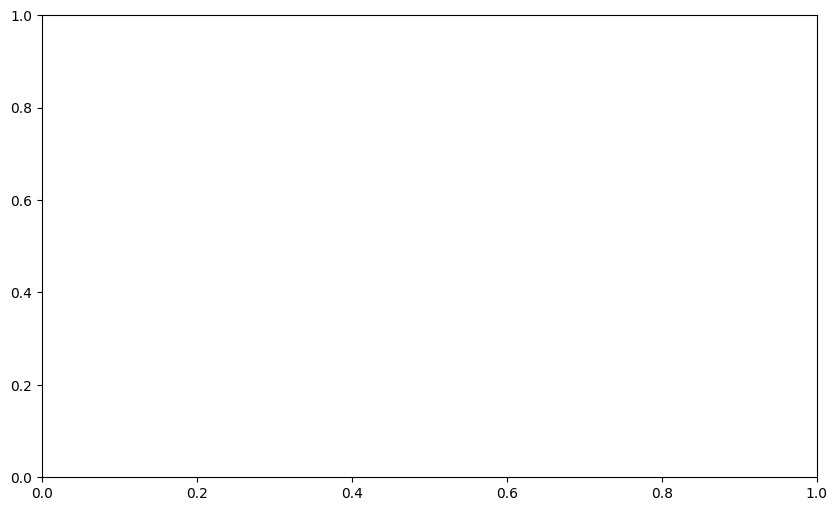

In [12]:
# Define a function to simulate step response
def simulate_step_response(Ad, Bd, Cd, dt, duration=10):
    x = np.zeros(Ad.shape[0])
    responses = []

    for t in np.arange(0, duration, dt):
        responses.append(Cd.dot(x))
        x = Ad.dot(x) + Bd  # Assume unit step input

    return np.arange(0, duration, dt), responses

# Simulate step response for each method
t_forward, response_forward = simulate_step_response(Ad_forward, Bd_forward, Cd_forward, dt)
t_backward, response_backward = simulate_step_response(Ad_backward, Bd_backward, Cd_backward, dt)
t_tustin, response_tustin = simulate_step_response(Ad_tustin, Bd_tustin, Cd_tustin, dt)

# Plot the responses
plt.figure(figsize=(10, 6))
plt.plot(t_forward, response_forward, label='Euler Forward')
plt.plot(t_backward, response_backward, label='Euler Backward')
plt.plot(t_tustin, response_tustin, label='Tustin')
plt.xlabel('Time (seconds)')
plt.ylabel('Response')
plt.title('Step Response of Discretized Systems')
plt.legend()
plt.grid(True)
plt.show()

## Exercise 3: Performance Analysis under Varying Time Steps

Objective: Evaluate how the choice of time step affects the performance of each discretization method.

Tasks:

	1.Vary the time step (e.g., dt = 0.05, 0.1, 0.2 seconds) and discretize the system using each method.
	2.Simulate the step response for each case.
	3.Plot the responses for different time steps and compare how each method reacts to changes in the time step.

## Solution Exercise 3

This exercise can be implemented by varying dt in the above code for Exercise 2 and plotting the responses for each dt value. The implementation would follow a similar structure, iterating over different dt values.